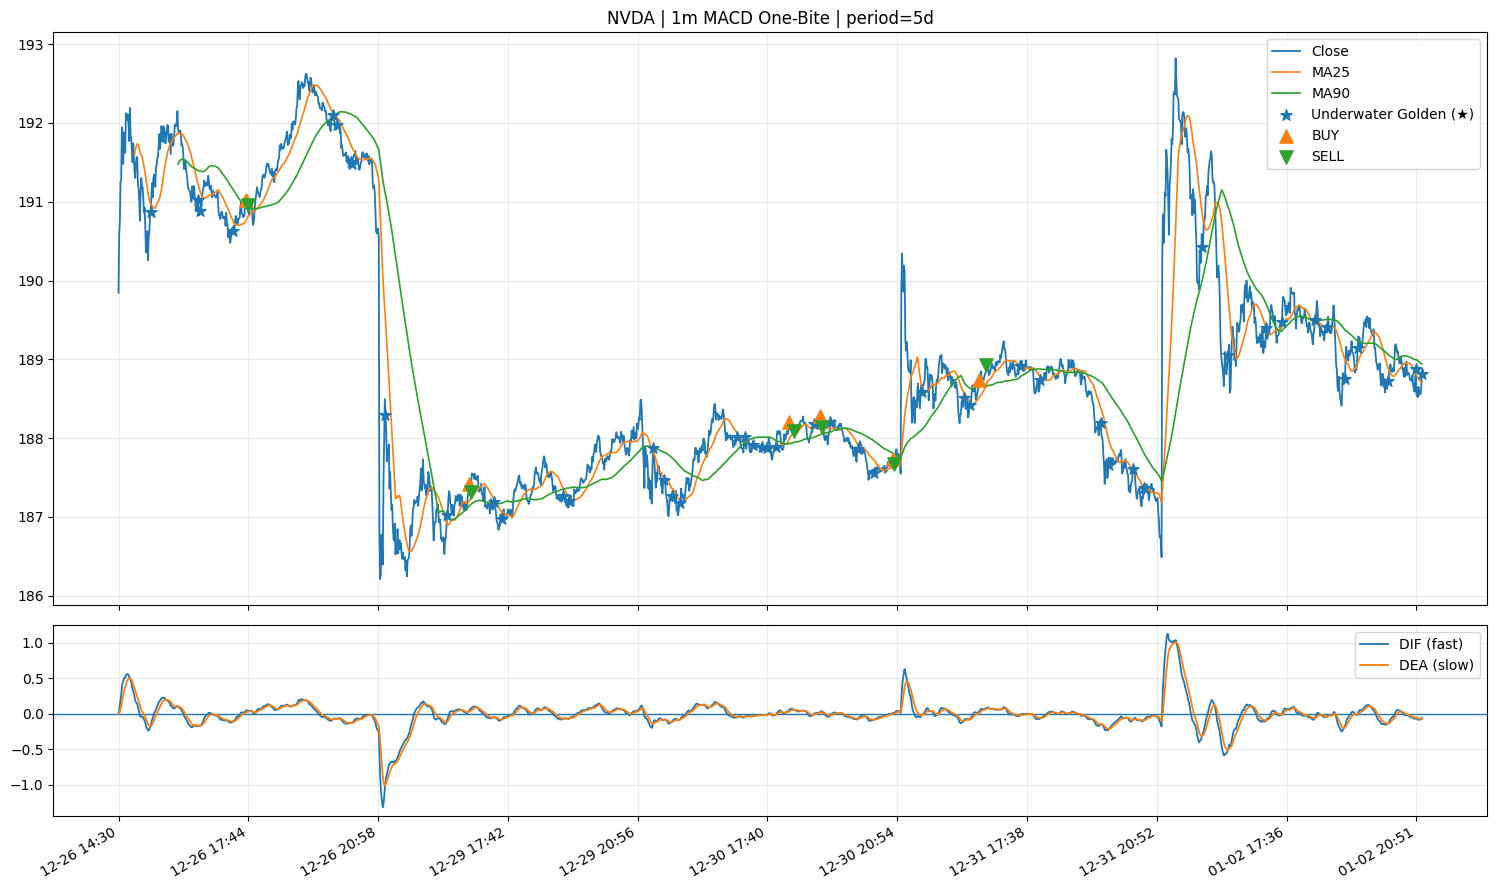

In [6]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ✅ 方案A：鼠标悬停显示信息
import mplcursors


# -----------------------------
# Helpers
# -----------------------------
def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def sma(s: pd.Series, n: int) -> pd.Series:
    return s.rolling(n, min_periods=n).mean()


# -----------------------------
# Indicators: MACD + MA25/MA90
# -----------------------------
def add_macd(df: pd.DataFrame, fast=12, slow=26, signal=9) -> pd.DataFrame:
    df = df.copy()
    df["EMA_fast"] = ema(df["Close"], fast)
    df["EMA_slow"] = ema(df["Close"], slow)
    df["DIF"] = df["EMA_fast"] - df["EMA_slow"]            # DIF 蓝线（快）
    df["DEA"] = ema(df["DIF"], signal)                      # DEA 橙线（慢）
    df["HIST"] = df["DIF"] - df["DEA"]
    return df

def add_mas(df: pd.DataFrame, n1=25, n2=90) -> pd.DataFrame:
    df = df.copy()
    df[f"MA{n1}"] = sma(df["Close"], n1)
    df[f"MA{n2}"] = sma(df["Close"], n2)
    return df


# -----------------------------
# Strategy: "MACD只吃一口"（1m版）
# -----------------------------
def macd_one_bite_signals(
    df: pd.DataFrame,
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    breakout_use_close: bool = True,
    exec_next_open: bool = False,
    # 回踩必须贴近0轴
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
) -> pd.DataFrame:
    d = df.copy()
    dif = d["DIF"]
    dea = d["DEA"]
    close = d["Close"]
    high = d["High"]
    low = d["Low"]
    open_ = d["Open"]

    # 水下金叉：DIF上穿DEA 且两者都<0
    golden = (dif > dea) & (dif.shift(1) <= dea.shift(1))
    underwater = (dif < 0) & (dea < 0)
    underwater_golden = (golden & underwater).fillna(False)

    # DIF 上穿0轴
    cross0 = ((dif >= 0) & (dif.shift(1) < 0)).fillna(False)

    d["BUY"] = False
    d["SELL"] = False
    d["ENTRY"] = np.nan
    d["SL"] = np.nan
    d["TP"] = np.nan
    d["EXIT"] = np.nan
    d["EXIT_REASON"] = ""

    n = len(d)
    i = 1
    in_trade = False
    entry = sl = tp = None

    state = "WAIT_UNDER_GOLDEN"
    cross0_idx = None
    peak_high = None
    pullback_started = False
    touched_zero = False

    while i < n:
        if in_trade:
            hit_sl = low.iloc[i] <= sl
            hit_tp = high.iloc[i] >= tp

            if hit_sl or hit_tp:
                d.at[d.index[i], "SELL"] = True
                if hit_sl and hit_tp:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL&TP_samebar->SL"
                elif hit_sl:
                    d.at[d.index[i], "EXIT"] = sl
                    d.at[d.index[i], "EXIT_REASON"] = "SL"
                else:
                    d.at[d.index[i], "EXIT"] = tp
                    d.at[d.index[i], "EXIT_REASON"] = "TP"

                in_trade = False
                entry = sl = tp = None

                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

        if state == "WAIT_UNDER_GOLDEN":
            if underwater_golden.iloc[i]:
                state = "WAIT_CROSS0"
            i += 1
            continue

        if state == "WAIT_CROSS0":
            if cross0.iloc[i]:
                cross0_idx = i
                peak_high = float(high.iloc[i])
                pullback_started = False
                touched_zero = False
                state = "WAIT_PULLBACK"
            i += 1
            continue

        if state == "WAIT_PULLBACK":
            if cross0_idx is not None and (i - cross0_idx) > pullback_max_bars:
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            peak_high = max(peak_high, float(high.iloc[i]))

            if not pullback_started:
                if dif.iloc[i] < dif.iloc[i - 1]:
                    pullback_started = True
                i += 1
                continue

            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False
                i += 1
                continue

            if abs(float(dif.iloc[i])) <= float(touch_zero_band):
                touched_zero = True

            if dif.iloc[i] >= dif.iloc[i - 1]:
                if pullback_touch_zero and (not touched_zero):
                    i += 1
                    continue
                state = "WAIT_BREAKOUT"

            i += 1
            continue

        if state == "WAIT_BREAKOUT":
            broke = (close.iloc[i] > peak_high) if breakout_use_close else (high.iloc[i] > peak_high)

            if broke:
                if exec_next_open and i + 1 < n:
                    entry = float(open_.iloc[i + 1])
                    buy_idx = i + 1
                else:
                    entry = float(close.iloc[i])
                    buy_idx = i

                sl = float(low.iloc[i])  # 突破那根K线低点
                tp = entry + 2.0 * (entry - sl)

                d.at[d.index[buy_idx], "BUY"] = True
                d.at[d.index[buy_idx], "ENTRY"] = entry
                d.at[d.index[buy_idx], "SL"] = sl
                d.at[d.index[buy_idx], "TP"] = tp

                in_trade = True
                i = buy_idx + 1
                continue

            if dif.iloc[i] < (0.0 - allow_touch_eps):
                state = "WAIT_UNDER_GOLDEN"
                cross0_idx = None
                peak_high = None
                pullback_started = False
                touched_zero = False

            i += 1
            continue

    return d


# -----------------------------
# Plot (1m) + Hover tooltips (mplcursors)
# -----------------------------
def plot_macd_one_bite_1m(
    ticker: str,
    period: str = "7d",
    interval: str = "1m",
    macd_fast: int = 12,
    macd_slow: int = 26,
    macd_signal: int = 9,
    # strategy knobs
    pullback_max_bars: int = 200,
    allow_touch_eps: float = 0.0,
    pullback_touch_zero: bool = True,
    touch_zero_band: float = 0.02,
    breakout_use_close: bool = True,
):
    df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
    if df is None or len(df) < 200:
        print(f"[{ticker}] Not enough 1m data. Try period='5d' or '7d'.")
        return

    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns = [c.strip().title() for c in df.columns]
    df = df.dropna(subset=["Open", "High", "Low", "Close"]).copy()

    # nicer labels
    try:
        if getattr(df.index, "tz", None) is not None:
            df.index = df.index.tz_localize(None)
    except Exception:
        pass

    df = add_macd(df, fast=macd_fast, slow=macd_slow, signal=macd_signal)
    df = add_mas(df, 25, 90)

    sig = macd_one_bite_signals(
        df,
        pullback_max_bars=pullback_max_bars,
        allow_touch_eps=allow_touch_eps,
        breakout_use_close=breakout_use_close,
        exec_next_open=False,
        pullback_touch_zero=pullback_touch_zero,
        touch_zero_band=touch_zero_band,
    )

    # ✅ 只标水下金叉（★）在股价图上
    underwater_golden_star = (
        (sig["DIF"] > sig["DEA"]) &
        (sig["DIF"].shift(1) <= sig["DEA"].shift(1)) &
        (sig["DIF"] < 0) & (sig["DEA"] < 0)
    ).fillna(False).values

    x = np.arange(len(sig))

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(15, 9), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---- Price + MA25/MA90 ----
    line_close, = ax1.plot(x, sig["Close"], linewidth=1.3, label="Close")
    line_ma25,  = ax1.plot(x, sig["MA25"], linewidth=1.2, label="MA25")
    line_ma90,  = ax1.plot(x, sig["MA90"], linewidth=1.2, label="MA90")

    sc_star = None
    if underwater_golden_star.any():
        sc_star = ax1.scatter(
            x[underwater_golden_star],
            sig["Close"].values[underwater_golden_star],
            marker="*", s=70, zorder=7, label="Underwater Golden (★)"
        )

    # Buy/Sell points
    buy = sig["BUY"].fillna(False).values
    sell = sig["SELL"].fillna(False).values

    sc_buy = None
    sc_sell = None
    if buy.any():
        sc_buy = ax1.scatter(x[buy], sig["Close"].values[buy], marker="^", s=90, zorder=8, label="BUY")
    if sell.any():
        exit_px = sig["EXIT"].copy().fillna(sig["Close"])
        sc_sell = ax1.scatter(x[sell], exit_px.values[sell], marker="v", s=90, zorder=8, label="SELL")

    ax1.set_title(f"{ticker} | 1m MACD One-Bite | period={period}")
    ax1.grid(alpha=0.25)
    ax1.legend()

    # ---- MACD DIF/DEA/0-axis ----
    ax2.axhline(0.0, linewidth=1.0)
    line_dif, = ax2.plot(x, sig["DIF"], linewidth=1.3, label="DIF (fast)")
    line_dea, = ax2.plot(x, sig["DEA"], linewidth=1.3, label="DEA (slow)")
    ax2.grid(alpha=0.25)
    ax2.legend()

    step = max(len(sig) // 10, 1)
    ax2.set_xticks(x[::step])
    ax2.set_xticklabels(sig.index.strftime("%m-%d %H:%M")[::step], rotation=30, ha="right")

    # -----------------------------
    # ✅ Hover tooltips (mplcursors)
    # - hover on lines + markers
    # -----------------------------
    artists = [line_close, line_ma25, line_ma90, line_dif, line_dea]
    for a in [sc_star, sc_buy, sc_sell]:
        if a is not None:
            artists.append(a)

    cursor = mplcursors.cursor(artists, hover=True)

    @cursor.connect("add")
    def _on_add(sel):
        # sel.target = (x, y). Use x to map to row index
        try:
            xi = int(round(sel.target[0]))
        except Exception:
            xi = 0
        xi = max(0, min(xi, len(sig) - 1))

        t = sig.index[xi]
        row = sig.iloc[xi]

        # flags at this bar
        is_star = bool(underwater_golden_star[xi])
        is_buy = bool(row.get("BUY", False))
        is_sell = bool(row.get("SELL", False))

        tags = []
        if is_star:
            tags.append("★ Underwater Golden")
        if is_buy:
            tags.append("BUY")
        if is_sell:
            tags.append(f"SELL({row.get('EXIT_REASON','')})")

        tag_text = (" | ".join(tags) + "\n") if tags else ""

        # build tooltip text
        sel.annotation.set_text(
            f"{tag_text}"
            f"{t}\n"
            f"O:{row['Open']:.2f} H:{row['High']:.2f} L:{row['Low']:.2f} C:{row['Close']:.2f}\n"
            f"MA25:{row['MA25']:.2f}  MA90:{row['MA90']:.2f}\n"
            f"DIF:{row['DIF']:.4f}  DEA:{row['DEA']:.4f}\n"
            f"Entry:{(row['ENTRY'] if pd.notna(row['ENTRY']) else np.nan):.2f}  "
            f"SL:{(row['SL'] if pd.notna(row['SL']) else np.nan):.2f}  "
            f"TP:{(row['TP'] if pd.notna(row['TP']) else np.nan):.2f}"
        )

    plt.tight_layout()
    plt.show()


# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    stk = "NVDA"  # 输入股票代码
    plot_macd_one_bite_1m(
        stk,
        period="5d",
        interval="1m",
        pullback_touch_zero=True,
        touch_zero_band=0.02,
        breakout_use_close=True,
    )
